# Proyek Predictive Analysis: Student Performance (Multiple Linear Regression)
- **Nama:** Bizzati Hanif Raushan Fikri
- **Email:** bizzhanif@gmail.com
- **ID Dicoding:** MC006D5Y1740


- Dataset source : https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression/data

## **Project Domain: Predicting Student Performance**

Domain projek ini adalah membangun satu **model regresi** tunggal untuk memprediksi *Performance Index* siswa (skor 0–100) berdasarkan berbagai atribut kebiasaan belajar dan demografis, termasuk:

* `Hours Studied` (Total waktu belajar siswa sebelum tes)
* `Previous Scores` (Nilai tes mahasiswa sebelumnya)
* `Sleep Hours` (Rata-rata jam tidur per hari)
* `Sample Question Papers Practiced` (Jumlah soal latihan yang dikerjakan)
* `Extracurricular Activities` (Partisipasi kegiatan ekstrakurikuler: Yes/No)

Tujuannya adalah:

* Mengidentifikasi siswa yang memerlukan intervensi khusus
* Memahami kontribusi relatif tiap fitur terhadap hasil belajar
* Menyediakan rekomendasi kuantitatif untuk peningkatan performa

---

## **Problem Statements & Goals**

**Problem Statement:**

> 1. Bagaimana memprediksi *Performance Index* siswa baru berdasarkan kombinasi fitur numerik dan kategorikal di atas?
2. Algoritma regresi mana (Linear Regression, Ridge, Lasso) yang memberikan prediksi paling akurat?
3. Fitur apa yang krusial dalam meningkatkan performa siswa?

**Goal:**

>* Membangun satu pipeline regresi yang mencakup pra-pemrosesan (encoding & scaling), pelatihan, dan validasi menggunakan cross-validation.
* Mencapai metrik **MAE ≤ 5.0** pada test set.
* Menginterpretasi koefisien dan signifikansi fitur, termasuk `extracurricular_activities`.

**Solution Statement:**

> Implementasi pipeline scikit-learn yang terdiri dari:
>
> 1. `ColumnTransformer` untuk:
>
>    * `StandardScaler` pada fitur numerik
>    * `OneHotEncoder` (drop-first) pada `extracurricular_activities`
> 2. Menggunakan model regresi terbaik dari ketiga model (Linear Regression / Ridge / Lasso) dituning dengan `GridSearchCV` (5-fold CV).
> 3. Evaluasi performa akhir pada test set (MAE, R²) dan analisis koefisien untuk seleksi model.
> 4. Melakukan analisa feature importance

## Import library

In [3]:
# basic analytical tools; EDA, Visualization, etc.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data preparation and model training
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

## Exploratory Data Analysis (EDA)

Load data & cek kebenaran data

In [5]:
df = pd.read_csv("Student_Performance.csv")

print("\nDataFrame Info:")
print(df.info())
df.head()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


Cek statistika umum dataset

In [6]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


Memvisualisasikan distribusi data masing-masing kelas:
1. Menampilkan plot histogram dari seluruh data `numeric_cols` (fitur numerik)
2. Menampilkan pie chart dari fitur `Extracurricular Activities` sebagai fitur kategorikal sendiri

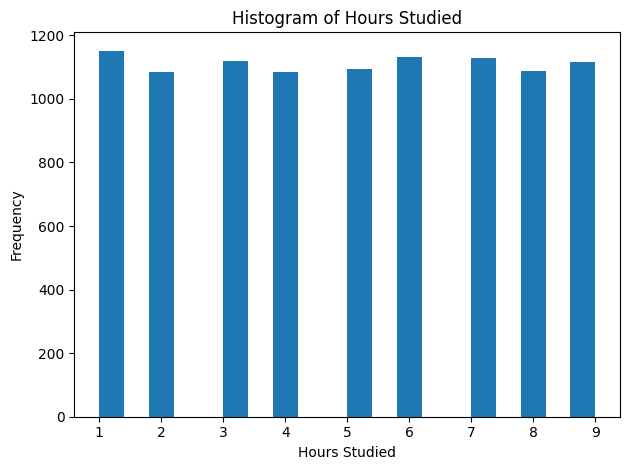

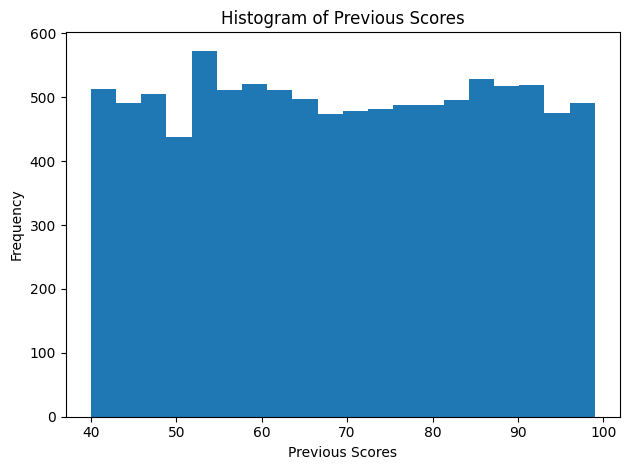

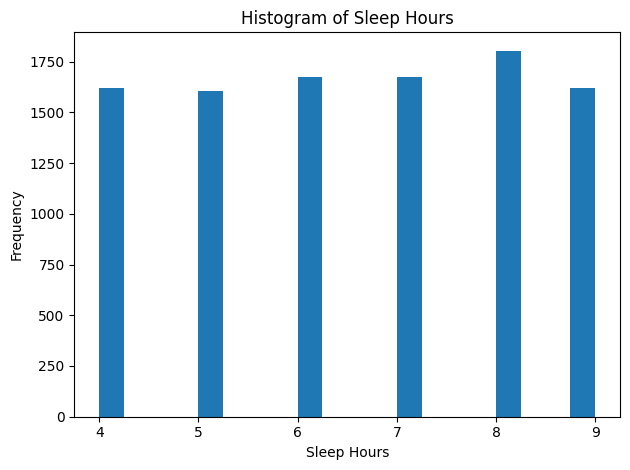

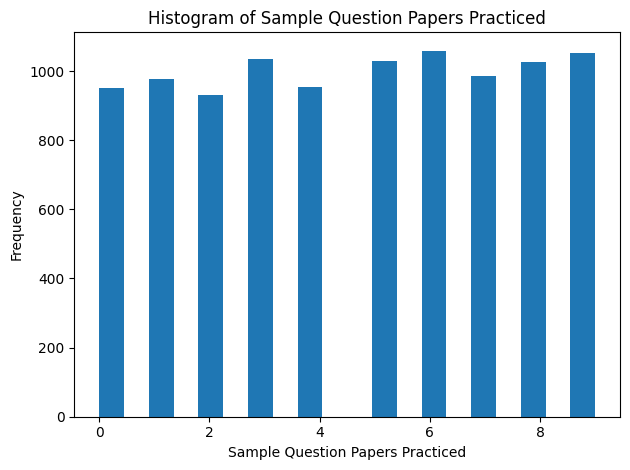

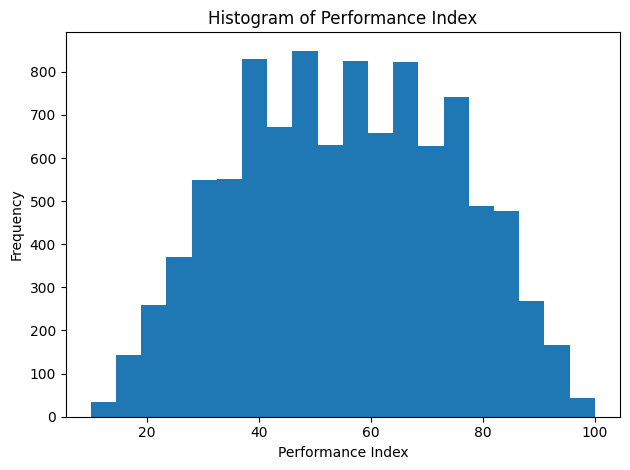

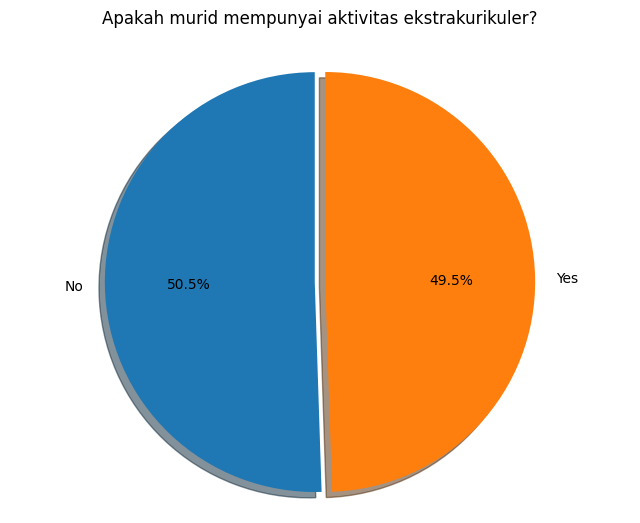

In [7]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    plt.figure()
    plt.hist(df[col], bins=20)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

ex_count = df['Extracurricular Activities'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(
    ex_count,
    labels=ex_count.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#1f77b4', '#ff7f0e'],
    explode= (0.05, 0),
    shadow=True,
    textprops={'fontsize': 10}
)

plt.title('Apakah murid mempunyai aktivitas ekstrakurikuler?', fontsize=12, pad=20)
plt.axis('equal')

plt.show()


Membuat dataframe sementara `df_encoded` untuk menyimpan encoding fitur kategorikal demi memplotting heatmap korelasi seluruh fitur

In [8]:
df_encoded = pd.concat([
    df[numeric_cols],
    pd.get_dummies(df['Extracurricular Activities'], prefix='Extra Activities', drop_first=True)
], axis=1)

corr_all = df_encoded.corr()

Membuat heatmap untuk melihat korelasi antar seluruh fitur

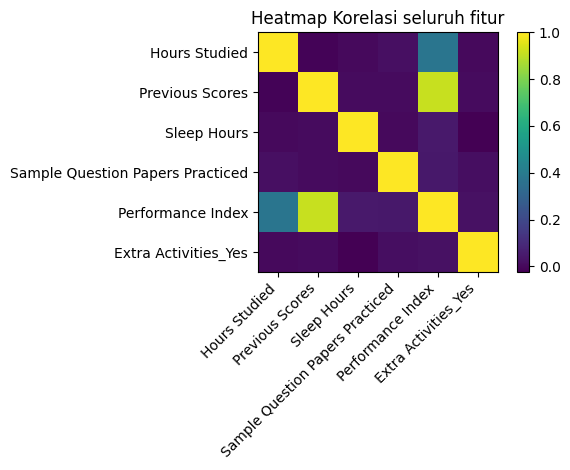

In [9]:
all_cols = df_encoded.columns

corr = df_encoded.corr()
plt.figure()
plt.imshow(corr, aspect='equal')
plt.colorbar()
plt.title('Heatmap Korelasi seluruh fitur')
plt.xticks(range(len(all_cols)), all_cols, rotation=45, ha='right')
plt.yticks(range(len(all_cols)), all_cols)
plt.tight_layout()
plt.show()

**Insight**
- Dari korelasi antar fitur, terlihat bahwa `performance_index` memiliki korelasi cukup erat dengan total jam belajar (`Hours Studied`) dan nilai sebelumnya (`Previous Scores`)

## Data preparation

### Preprocessing

Kode di bawah ini adalah beberapa proses pengecekan data yaitu:
1. Menghitung jumlah data null/ kosong dengan pemanggilan `df.isnull().sum()`
2. Menghitung jumlah data duplikat dengan pemanggilan `df.duplicated().sum()`
3. Mencari outlier dan mencatatnya pada set `outlier_indices` lalu dipanggil dengan
```python
print(f"Jumlah outlier yang terdeteksi: {len(outlier_indices)}")
```

In [10]:
print("Jumlah null pada dataframe:")
print(f"\n{df.isnull().sum()}")

print(f"\n\nJumlah duplikat pada Student_Performance.csv: {df.duplicated().sum()}")

def detect_outlier_indices(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)].index

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
outlier_indices = set()
for col in numeric_cols:
    outlier_indices.update(detect_outlier_indices(df[col]))

print(f"Jumlah outlier yang terdeteksi: {len(outlier_indices)}")

Jumlah null pada dataframe:

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


Jumlah duplikat pada Student_Performance.csv: 127
Jumlah outlier yang terdeteksi: 0


Kode di bawah adalah tahap penanganan data yang mencakup:
1. Penghapusan data null dengan `df.dropna()` lalu pengecekan ulang dengan `df_isnull().sum()`.
2. Penghapusan data duplikat dengan `df.drop_duplicates()` lalu pengecekan ulang dengan `df.duplicated().sum()`
3. Penghapusan data outlier dengan `df.drop(outlier_indices)` lalu pengecekan ulang dengan `print(len(outlier_indices))`

In [11]:
df_unprocessed = df.copy()

df.dropna(inplace=True)
print("Jumlah null pada dataframe setelah drop:")
print(f"\n{df.isnull().sum()}")

df.drop_duplicates(inplace=True)
print(f"\n\nJumlah duplikat pada Student_Performance.csv setelah drop: {df.duplicated().sum()}")

df.drop(outlier_indices, inplace=True)
print(f"Jumlah outlier yang terdeteksi setelah drop: {len(outlier_indices)}")

Jumlah null pada dataframe setelah drop:

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


Jumlah duplikat pada Student_Performance.csv setelah drop: 0
Jumlah outlier yang terdeteksi setelah drop: 0


**Insight:**
- Terdapat beberapa data duplikat yang ditangani dengan drop duplicates
- Tidak terdapat data null
- Tidak terdapat data outlier

### Data splitting & data preparation

split data menjadi dua bagian; data training 80% & data testing 20%

In [12]:
from sklearn.model_selection import train_test_split

X = df.drop('Performance Index', axis=1)
y = df['Performance Index']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

Membangun pipeline `preprocessor` untuk scaling fitur numerik serta encoding fitur kategorikal

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

numeric_feats = ['Hours Studied','Previous Scores','Sleep Hours','Sample Question Papers Practiced']
cat_feats     = ['Extracurricular Activities']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(drop='first'), cat_feats)
])

## Modeling

### Metrik Evaluasi

Untuk mengukur performa model dalam proyek ini, digunakan dua metrik utama:

#### 1. Mean Absolute Error (MAE)
- MAE menghitung rata-rata kesalahan absolut antara nilai aktual ($y_i$) dan prediksi ($\hat y_i$).
- Metrik ini cocok untuk regresi karena memberikan estimasi seberapa jauh prediksi rata-rata model dari nilai sebenarnya, dalam satuan asli target.
- MAE tidak terlalu sensitif terhadap outlier, sehingga memberikan penilaian yang lebih stabil.
- Semakin rendah nilai MAE berarti semakin bagus karena rata-rata kesalahan lebih rendah

**Formula MAE**:  
$$
{MAE} = \frac{1}{n} \sum_{i=1}^{n} \bigl|y_i - \hat y_i\bigr|
$$

#### 2. Koefisien Determinasi (R²)
- R² menunjukkan proporsi varians target yang berhasil dijelaskan oleh model.
- Nilai R² berkisar antara 0 hingga 1, di mana 1 berarti model menjelaskan semua variasi data, dan 0 berarti tidak ada penjelasan sama sekali.
- Metrik ini membantu menilai seberapa baik model menangkap pola data.

**Formula R²**:  
$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat y_i)^2}{\sum_{i=1}^{n} (y_i - \bar y)^2}
$$


### 1. Linear Regression

Proses training & evaluasi model:
1. Membuat pipeline untuk model linear regression di mana terdapat tahap yang berisi pipeline `preprocessor` sebelumnya serta tahap regresinya
2. Melakukan fitting pada data train
3. Melakukan prediksi dengan data test lalu menghitung skor MAE dan R2
4. `cv_mae_lr` adalah fungsi *cross validation* untuk menghasilkan skor rata-rata dari MAE pada tiap iterasi (5 iterasi) demi mengurangi variansi

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('reg', LinearRegression())
])

pipe_lr.fit(X_train, y_train)

y_pred_lr = pipe_lr.predict(X_test)
print("LinearRegression — Test MAE: {:.3f}, R²: {:.3f}".format(
    mean_absolute_error(y_test, y_pred_lr),
    r2_score(y_test, y_pred_lr)
))

cv_mae_lr = -cross_val_score(pipe_lr, X_train, y_train,
                             cv=5, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
print("LinearRegression — CV MAE (5-fold): {:.3f}".format(cv_mae_lr))


LinearRegression — Test MAE: 1.647, R²: 0.988
LinearRegression — CV MAE (5-fold): 1.619


### 2. Ridge Regression

Proses training & evaluasi model:
1. Membuat pipeline untuk model ridge regression di mana terdapat tahap yang berisi pipeline `preprocessor` sebelumnya serta tahap regresi dengan pengubahan parameter `max_iter=5000`
2. Mencari parameter terbaik untuk `alpha` dengan menguji beberapa input dalam array/grid dan mengambil model terbaik menggunakan `GridSearchCV()`bermetrik `neg_mean_absolute_error`
3. Melakukan fitting untuk grid pada data train
4. Melakukan prediksi dengan data test lalu menghitung dan menampilkan `alpha` terbaik dari tuning, skor MAE, R2, dan CV MAE

In [18]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

pipe_r = Pipeline([
    ('pre', preprocessor),
    ('reg', Ridge(max_iter=5000))
])

param_grid_r = {'reg__alpha': [0.1, 1, 10, 100]}

grid_r = GridSearchCV(
    pipe_r, param_grid_r,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_r.fit(X_train, y_train)

best_ridge = grid_r.best_estimator_
cv_mae_r = -grid_r.best_score_
print("Ridge    — Best alpha:", grid_r.best_params_['reg__alpha'])
print("Ridge    — CV MAE: {:.3f}".format(cv_mae_r))

y_pred_r = best_ridge.predict(X_test)
print("Ridge    — Test MAE: {:.3f}, R²: {:.3f}".format(
    mean_absolute_error(y_test, y_pred_r),
    r2_score(y_test, y_pred_r)
))

Ridge    — Best alpha: 0.1
Ridge    — CV MAE: 1.619
Ridge    — Test MAE: 1.647, R²: 0.988


### 3. Lasso Regression



Proses training & evaluasi model:
1. Membuat pipeline untuk model lasso regression di mana terdapat tahap yang berisi pipeline `preprocessor` sebelumnya serta tahap regresi dengan pengubahan parameter `max_iter=10000`
2. Mencari parameter terbaik untuk `alpha` dengan menguji beberapa input dalam array/grid dan mengambil model terbaik menggunakan `GridSearchCV()`bermetrik `neg_mean_absolute_error`
3. Melakukan fitting untuk grid pada data train
4. Melakukan prediksi dengan data test lalu menghitung dan menampilkan `alpha` terbaik dari tuning, skor MAE, R2, dan CV MAE

In [19]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

pipe_l = Pipeline([
    ('pre', preprocessor),
    ('reg', Lasso(max_iter=10000,))
])

param_grid_l = {'reg__alpha': [0.001, 0.01, 0.1, 1, 10]}

grid_l = GridSearchCV(
    pipe_l, param_grid_l,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_l.fit(X_train, y_train)

best_lasso = grid_l.best_estimator_
cv_mae_l = -grid_l.best_score_
print("Lasso    — Best alpha:", grid_l.best_params_['reg__alpha'])
print("Lasso    — CV MAE: {:.3f}".format(cv_mae_l))

y_pred_l = best_lasso.predict(X_test)
print("Lasso    — Test MAE: {:.3f}, R²: {:.3f}".format(
    mean_absolute_error(y_test, y_pred_l),
    r2_score(y_test, y_pred_l)
))

Lasso    — Best alpha: 0.001
Lasso    — CV MAE: 1.619
Lasso    — Test MAE: 1.647, R²: 0.988


## Evaluation

Merangkup hasil evaluasi dari ketiga model yang diuji dan menyimpannya pada `df_results` untuk dipanggil

In [20]:
import pandas as pd

df_results = pd.DataFrame([
    ['Linear', mean_absolute_error(y_test, y_pred_lr), r2_score(y_test, y_pred_lr), cv_mae_lr],
    ['Ridge',  mean_absolute_error(y_test, y_pred_r),  r2_score(y_test, y_pred_r),  cv_mae_r],
    ['Lasso',  mean_absolute_error(y_test, y_pred_l),  r2_score(y_test, y_pred_l),  cv_mae_l]
], columns=['Model','Test MAE','Test R2','CV MAE']).set_index('Model')

print(df_results)

        Test MAE   Test R2    CV MAE
Model                               
Linear  1.646970  0.988430  1.618631
Ridge   1.646969  0.988430  1.618631
Lasso   1.647110  0.988428  1.618629


**Insight:**
- Perbandingan antar ketiga model tidak menunjukkan perbedaan yang signifikan, ini menunjukkan ketiga model regresi tersebut setara dalam performa. Namun jika kita ingin lebih teliti model **Ridge** memiliki skor Mean Absolut Error (MAE) yang paling rendah, sehingga model **Ridge** dapat disimpulkan sebagai model yang paling efektif untuk digunakan

- Skor MAE dari hasil Cross Validation tidak digunakan untuk menggambarkan contoh nyata ketika model dideploy. CV MAE hanya digunakan untuk pengecekan overfitting jika skor CV MAE lebih tinggi dibanding skor MAE

Menguji *feature importance* untuk melihat fitur yang paling berkontribusi pada model terbaik:
1. Memanggil pipeline model ridge regression untuk mengambil koefisiennya
2. Menyimpan koefisien pada dataframe baru `coef_df`
3. Hitung kontribusi relatif masing-masing koefisien dan menyimpannya ke bentuk %
4. Urutkan baris fitur berdasarkan kontribusi tertinggi
5. Cetak hasil

In [22]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

best_ridge = grid_r.best_estimator_

model = best_ridge.named_steps['reg']
pre   = best_ridge.named_steps['pre']

numeric_feats = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
cat_feats     = ['Extracurricular Activities']
onehot        = pre.named_transformers_['cat']
cat_columns   = onehot.get_feature_names_out(cat_feats)
feature_names = numeric_feats + list(cat_columns)

coefs = model.coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})

coef_df['AbsCoef'] = coef_df['Coefficient'].abs()
total = coef_df['AbsCoef'].sum()
coef_df['Contribution (%)'] = coef_df['AbsCoef'] / total * 100

coef_df = coef_df.sort_values('Contribution (%)', ascending=False)

print("\nRidge Feature Importance (relative contribution):")
for _, row in coef_df.iterrows():
    print(f"- {row.Feature:30s}: {row['Contribution (%)']:5.1f}% (coef = {row.Coefficient:.3f})")



Ridge Feature Importance (relative contribution):
- Previous Scores               :  65.5% (coef = 17.620)
- Hours Studied                 :  27.4% (coef = 7.373)
- Sleep Hours                   :   3.0% (coef = 0.802)
- Extracurricular Activities_Yes:   2.1% (coef = 0.574)
- Sample Question Papers Practiced:   2.0% (coef = 0.540)


**Insight:**
- Pengujian feature importance di atas menunjukkan bahwa nilai sebelumnya (`previous scores`) memiliki dampak terbesar terhadap index performa siswa, begitu pula total jam belajar (`Hours Studied`) dengan koefisien 27.4%

## Conclusion

## Goals

* Membangun satu pipeline regresi yang mencakup pra-pemrosesan (encoding & scaling), pelatihan, dan validasi menggunakan cross-validation. ✅
* Mencapai metrik **MAE ≤ 5.0** pada test set. ✅
* Menginterpretasi koefisien dan signifikansi fitur ✅

---

## Results

Berdasarkan **evaluasi test set**:

| Model             | Test MAE | Test R² | CV MAE |
| ----------------- | -------- | ------- | -------|
| Linear Regression | 1.646    | 0.988   | 1.618  |
| Ridge Regression  | 1.646    | 0.988   | 1.618  |
| Lasso Regression  | 1.647    | 0.988   | 1.618  |

- Semua model memberikan performa yang sangat mirip, dengan **MAE ≈ 1.65** dan **R² ≈ 0.988**.
- **Linear Regression** sudah mampu menangkap pola linier data dengan sangat baik tanpa regularisasi tambahan.
- **Ridge Regression** pilihan terbaik secara teknis, karena memberikan perfoma paling stabil, meskipun sangat tipis lebih baik daripada Linear.
- **Lasso Regression** bisa menyederhanakan model dengan meng-nol-kan fitur, tapi tidak terjadi dalam kasus ini (karena semua fitur cukup relevan).

**Analisis Koefisien (Ridge Regression):**

| Feature                          | Contribution (%) | Coefficient |
| -------------------------------- | ---------------- | ----------- |
| Previous Scores                  | 65.5%            | 17.620      |
| Hours Studied                    | 27.4%            | 7.373       |
| Sleep Hours                      | 3.0%             | 0.802       |
| Extracurricular Activities (Yes) | 2.1%             | 0.574       |
| Sample Question Papers Practiced | 2.0%             | 0.540       |

* **Prediksi kuat** didorong oleh `Previous Scores` dan `Hours Studied` (total >92% kontribusi).
* Fitur lain memberikan kontribusi positif kecil, termasuk `extracurricular_activities`.

---

## Solusi setelah analisis

1. **Prediksi Performance Index**: Model **Ridge Regression** memenuhi target MAE ≤ 5.0 dengan skor terendah MAE ≈ 1.65 dan R² ≈ 0.988.
2. **Algoritma Terbaik**: Ketiga algoritma (Linear, Ridge, Lasso) memiliki performa setara, sehingga Linear Regression dipilih karena kesederhanaan dan interpretabilitas.
3. **Rekomendasi**: Berdasarkan koefisien, peningkatan **Previous Scores** dan **Hours Studied** adalah strategi paling efektif untuk menaikkan skor siswa.

Model ini siap digunakan sebagai alat bantu keputusan untuk intervensi akademik di lembaga pendidikan.
